In [2]:
# Imports 

import numpy as np
from scipy.ndimage import convolve  
import matplotlib.pyplot as plt
import matplotlib as mpl 
import cv2 
import scipy
from PIL import Image

# Helper Functions 

def show_binary_image(image, title=None):

    # Converts from one colour space to the other. this is needed as RGB
    # is not the default colour space for OpenCV

    # Show the image
    plt.imshow(image, cmap=plt.cm.gray)
    

    # remove the axis / ticks for a clean looking image
    plt.xticks([])
    plt.yticks([])

    # if a title is provided, show it
    if title is not None:
        plt.title(title)

    plt.show()

# Task 1: Laplacian of Gaussian

In [3]:
# Open the GIF image
gif_image = Image.open('images/shakey.150.gif')

# Let's just take the first frame (index 0) for the static PNG
gif_image.seek(0) 

# Save the current frame as PNG
gif_image.save('images/shakey.png')

# Import PNG
image = cv2.imread("images/shakey.png", cv2.IMREAD_GRAYSCALE)

# Zero padding
# image = np.pad(image1, pad_width=4, mode='constant', constant_values=0)
image.shape

(1500, 1117)

In [4]:
def laplacian_of_gaussian(size: int = 9, sigma: float = 2.0) -> np.ndarray:

    # Create a grid of coordinates
    x, y = np.meshgrid(np.arange(-size//2 + 1, size//2 + 1),
                       np.arange(-size//2 + 1, size//2 + 1))

    # Compute the Laplacian of Gaussian
    log = ((x**2 + y**2 - 2*sigma**2) / (sigma**4)) * np.exp(-(x**2 + y**2) / (2*sigma**2))

    # Normalize the mask
    log = log - np.mean(log)
    log = log / np.max(np.abs(log))
    
    return log


# Create Filter
log_mask = laplacian_of_gaussian(9, 2)

# Apply to image
log_image = scipy.signal.convolve2d(image, log_mask, mode='same')
log_image.shape


(1500, 1117)

In [5]:
def zero_crossing(image, thresh=175): 
    
    z_c_image = np.zeros(image.shape)
    h,w = image.shape
    for y in range(1, h - 1):
        for x in range(1, w - 1):
            patch = image[y-1:y+2, x-1:x+2]
            p = image[y, x]
            maxP = patch.max()
            minP = patch.min()
            if (p > 0):
                zeroCross = True if minP < 0 else False
            else:
                zeroCross = True if maxP > 0 else False
            if ((maxP - minP) > thresh) and zeroCross:
                z_c_image[y, x] = 1
    return z_c_image


edge_image = zero_crossing(log_image)
edge_image.shape

(1500, 1117)

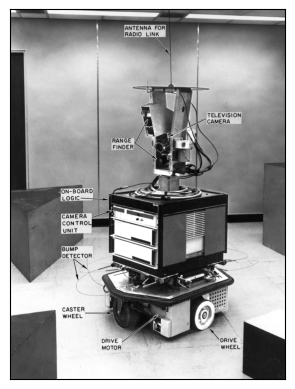

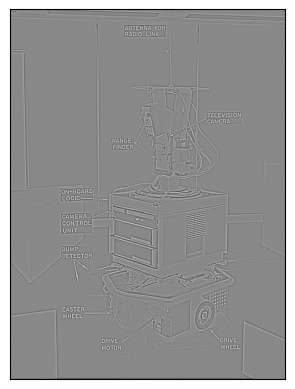

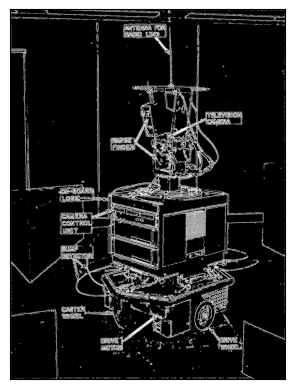

In [6]:
show_binary_image(image)
show_binary_image(log_image)
show_binary_image(edge_image)


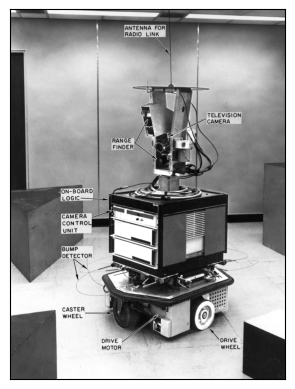

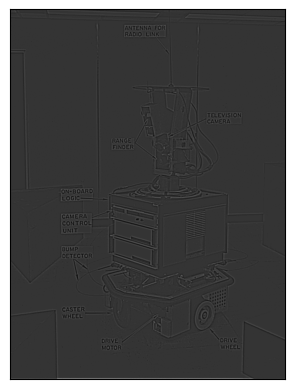

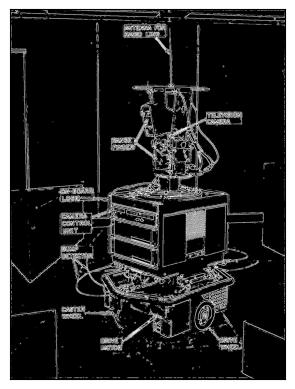

In [7]:

def gaussian_kernel(size: int = 9, sigma: float = 2.0) -> np.ndarray: 
    """
    Generates a Gaussian kernel matrix for applying a Gaussian blur filter. 
    The kernel generated is a square matrix of dimensions size x size, 
    centered around the matrix origin, with values computed from the 2D Gaussian function.

    Parameters:
    - size (int, optional): The size of one side of the square Gaussian kernel. Must be a positive odd integer
      to ensure the kernel has a center. Defaults to 9, resulting in a 9x9 kernel.
    - sigma (float, optional): The standard deviation of the Gaussian distribution used in the
      kernel's calculation. This controls the spread of the blur; a larger sigma results in a blurrier image.
      Defaults to 2.0. 

    Returns:
    - np.ndarray: A 2D Numpy array of shape (size, size) containing the Gaussian kernel. The values
      are of type `np.float64`, ensuring high precision for the calculations. The kernel is normalized so that
      its sum equals 1, making it suitable for convolution operations without altering the image brightness.
   """ 

    size = int(size) // 2  # Ensuring the kernel size is effectively odd
    x, y = np.mgrid[-size:size+1, -size:size+1]  # Create a grid of (x, y) coordinates
    normal = 1 / (2.0 * np.pi * sigma**2)  # Normalization constant for the Gaussian function
    g = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal  # Compute the Gaussian function
    return g / np.sum(g)  # Normalize and return the kernel


laplacian_kernel = np.array([[-1,-1,-1],
                    [-1, 8, -1],
                    [-1,-1,-1]])

g = gaussian_kernel()

smooth_image = scipy.signal.convolve2d(image, g, mode='same')
log_image = scipy.signal.convolve2d(smooth_image, laplacian_kernel, mode='same')
# log_image1 = np.pad(log_image1, pad_width=1, mode='constant', constant_values=0)

edge_image = zero_crossing(log_image, thresh=10)

show_binary_image(image)
show_binary_image(log_image)
show_binary_image(edge_image)


In [8]:
edge_image.shape

(1500, 1117)

# Task 2: Edge Detection

In [9]:
roberts_x = np.array([[1, 0],
                     [0, -1]])

roberts_y = np.array([[0, 1],
                      [-1, 0]])


sobel_x = np.array([[1, 0, -1],
                    [2, 0, -2],
                    [1, 0, -1]])

sobel_y = sobel_x.T #The roberts_y operator is the transpose of roberts_x and vice versa

def magnitude_img(G_x: np.ndarray, G_y: np.ndarray) -> np.ndarray:
    """
    Computes the magnitude of the gradient for an image given its horizontal (G_x)
    and vertical (G_y) gradients.

    Parameters:
    - G_x (np.ndarray): The gradient of the image in the x-direction (horizontal).
    - G_y (np.ndarray): The gradient of the image in the y-direction (vertical).

    Returns:
    - np.ndarray: The magnitude of the gradient at each point in the image. The returned
      array is of the same shape as the input arrays and contains the computed gradient
      magnitudes.
    """
    return np.sqrt(G_x**2 + G_y**2) 
  
def apply_sobel_filter(image: np.ndarray, gaussian_size: int = 9, sigma: float = 2.0, threshold: int = 50) -> np.ndarray:
  g = gaussian_kernel(gaussian_size, sigma)
  smoothed_image = scipy.signal.convolve2d(image, g, mode='same')
  G_x = scipy.signal.convolve2d(smoothed_image, sobel_x, mode='same')
  G_y = scipy.signal.convolve2d(smoothed_image, sobel_y, mode='same')
  edge_image = magnitude_img(G_x, G_y) >= threshold
  return edge_image  # Ensuring return type is consistent

def apply_roberts_filter(image: np.ndarray, gaussian_size: int = 9, sigma: float = 2.0, threshold: int = 50) -> np.ndarray:
  g = gaussian_kernel(gaussian_size, sigma)
  smoothed_image = scipy.signal.convolve2d(image, g, mode='same')
  G_x = scipy.signal.convolve2d(smoothed_image, roberts_x, mode='same')
  G_y = scipy.signal.convolve2d(smoothed_image, roberts_y, mode='same')
  edge_image = magnitude_img(G_x, G_y) >= threshold
  return edge_image  # Ensuring return type is consistent

def apply_first_order_gaussian(image: np.ndarray, gaussian_size: int = 9, sigma: float = 2.0, threshold: int = 50) -> np.ndarray:
    # Create a grid of coordinates for derivative computation
    x, y = np.meshgrid(np.arange(-gaussian_size//2 + 1, gaussian_size//2 + 1),
                       np.arange(-gaussian_size//2 + 1, gaussian_size//2 + 1))
    
    # Gaussian kernel for smoothing
    g = gaussian_kernel(gaussian_size, sigma)
    
    # First-order derivatives of Gaussian
    G_x = - (x / sigma**2) * g
    G_y = - (y / sigma**2) * g
    
    # Convolve image with G_x and G_y to get horizontal and vertical gradients
    grad_x = scipy.signal.convolve2d(image, G_x, mode='same', boundary='symm')
    grad_y = scipy.signal.convolve2d(image, G_y, mode='same', boundary='symm')
    
    # Compute gradient magnitude
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    
    # Threshold gradient magnitude to detect edges
    edge_image = magnitude >= threshold
    
    return edge_image  # Ensuring return type is consistent

laplacian_kernel = np.array([[-1,-1,-1],
                    [-1, 8, -1],
                    [-1,-1,-1]])

def apply_laplacian_filter(image: np.ndarray, gaussian_size: int = 9, sigma: float = 2.0, threshold: int = 50) -> np.ndarray:
  image = scipy.signal.convolve2d(image, laplacian_kernel, mode='same')
  edge_image = zero_crossing(image, threshold)
  return edge_image

def apply_LoG_filter(image: np.ndarray, gaussian_size: int = 9, sigma: float = 2.0, threshold: int = 50) -> np.ndarray:
  g = gaussian_kernel(gaussian_size, sigma)
  smoothed_image = scipy.signal.convolve2d(image, g, mode='same')
  log_image = scipy.signal.convolve2d(smoothed_image, laplacian_kernel, mode='same')
  edge_image = zero_crossing(log_image, threshold)
  return edge_image

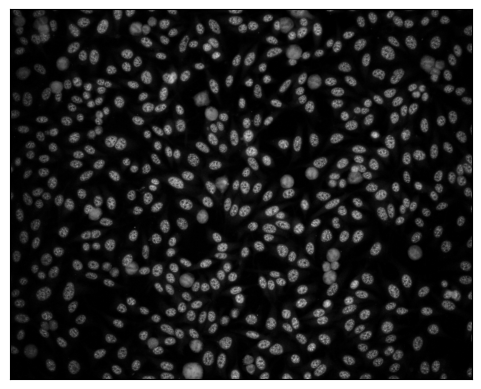

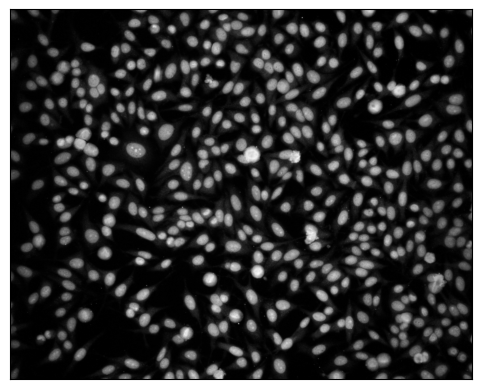

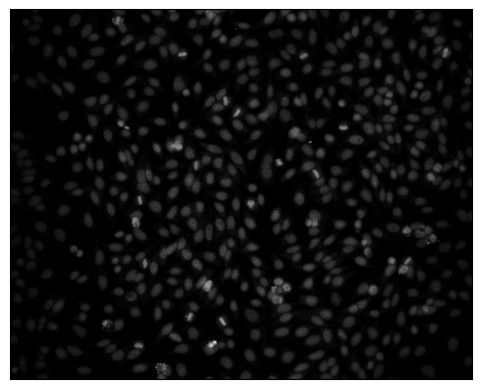

In [10]:
image1 = cv2.imread("images/cells/9343 AM.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 
image2 = cv2.imread("images/cells/10905 JL.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 
image3 = cv2.imread("images/cells/43590 AM.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 

show_binary_image(image1)
show_binary_image(image2)
show_binary_image(image3)

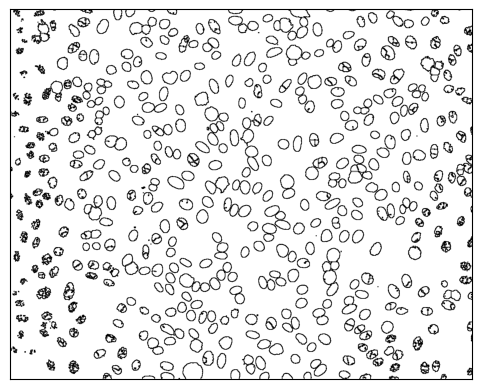

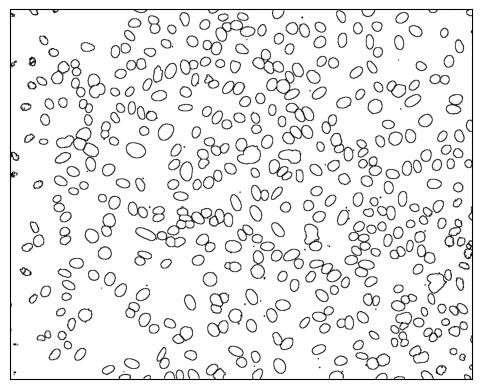

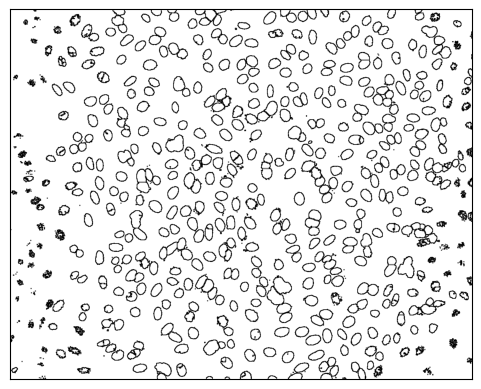

In [25]:
ground_truth1 = cv2.imread("images/cells/9343 AM Edges.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 
ground_truth2 = cv2.imread("images/cells/10905 JL Edges.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 
ground_truth3 = cv2.imread("images/cells/43590 AM Edges.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 

show_binary_image(ground_truth1)
show_binary_image(ground_truth2)
show_binary_image(ground_truth3)

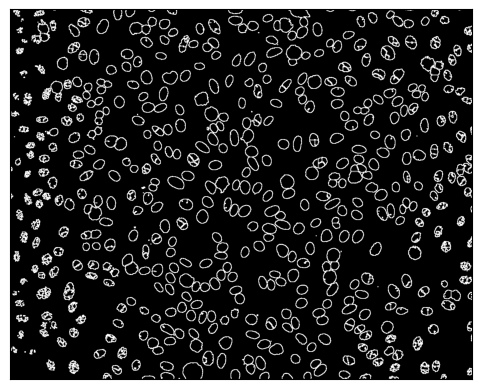

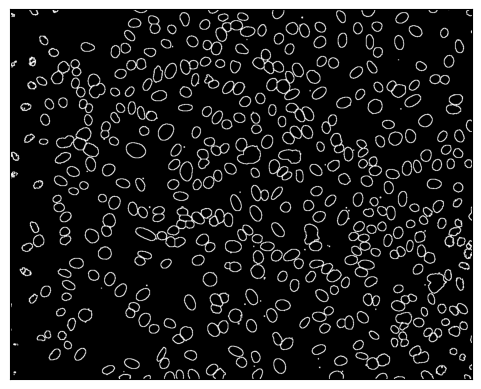

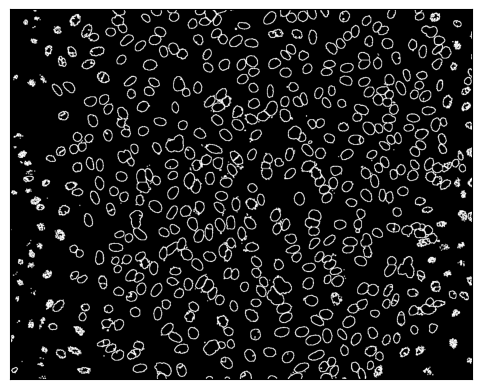

In [34]:
import numpy as np

def preprocess_ground_truth(image: np.ndarray):
    # Create a new array where True is set for elements that are 0 in the original image, and False otherwise
    mask = image == 0
    
    # Convert the boolean mask to integer (1 for True, 0 for False)
    preprocessed_image = mask.astype(int)
    
    return preprocessed_image


ground_truth1 = preprocess_ground_truth(ground_truth1)
ground_truth2 = preprocess_ground_truth(ground_truth2)
ground_truth3 = preprocess_ground_truth(ground_truth3)
show_binary_image(ground_truth1)
show_binary_image(ground_truth2)
show_binary_image(ground_truth3)

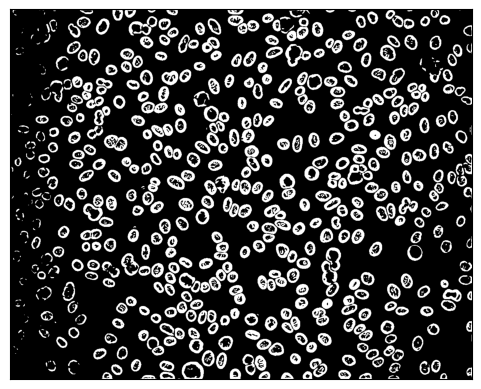

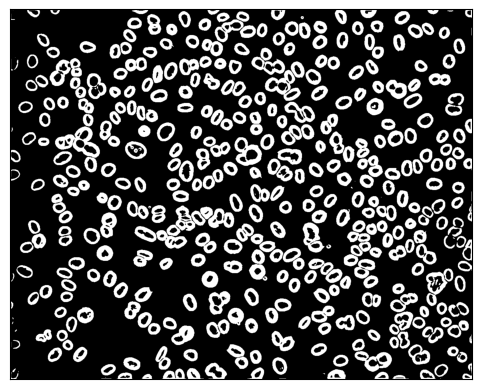

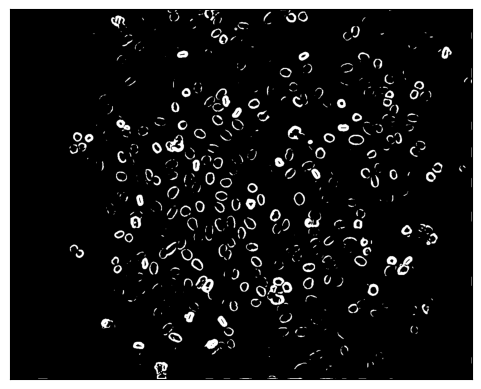

In [16]:
sobel_edge_image1 = apply_sobel_filter(image1, threshold=25)
sobel_edge_image2 = apply_sobel_filter(image2, threshold=25)
sobel_edge_image3 = apply_sobel_filter(image3, threshold=25)

show_binary_image(sobel_edge_image1)
show_binary_image(sobel_edge_image2)
show_binary_image(sobel_edge_image3)

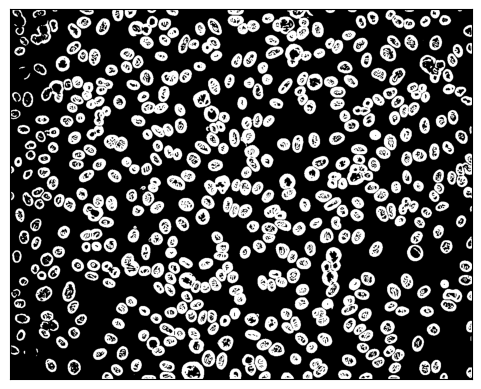

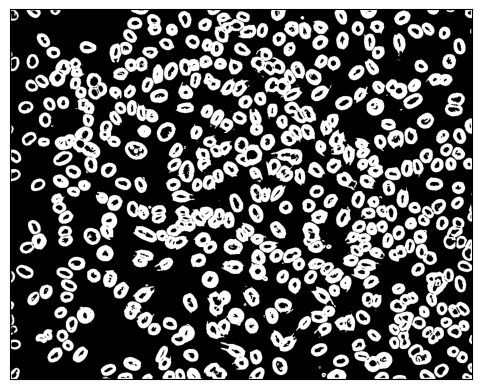

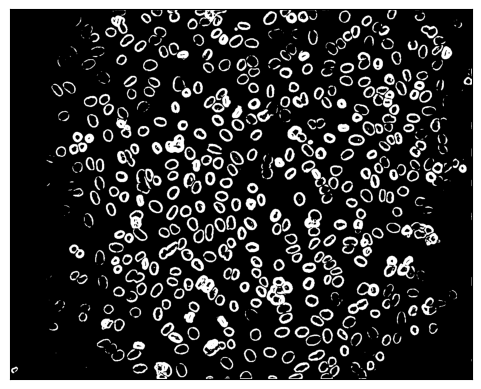

In [21]:
roberts_edge_image1 = apply_roberts_filter(image1, threshold=3)
roberts_edge_image2 = apply_roberts_filter(image2, threshold=3)
roberts_edge_image3 = apply_roberts_filter(image3, threshold=3)

show_binary_image(roberts_edge_image1)
show_binary_image(roberts_edge_image2)
show_binary_image(roberts_edge_image3)

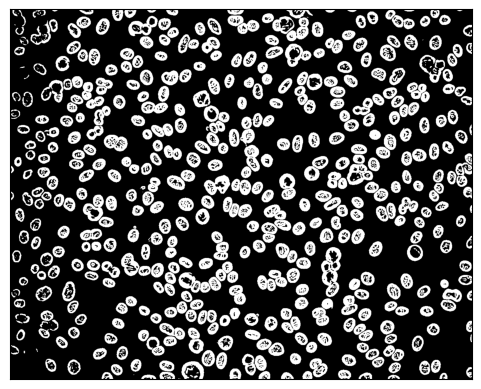

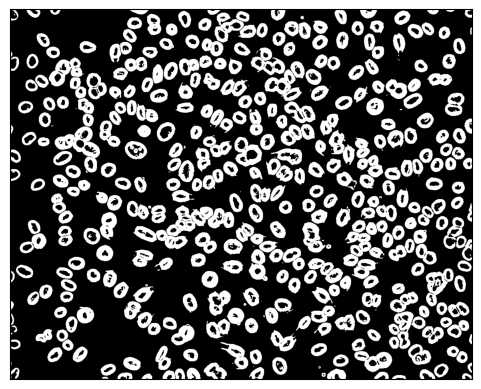

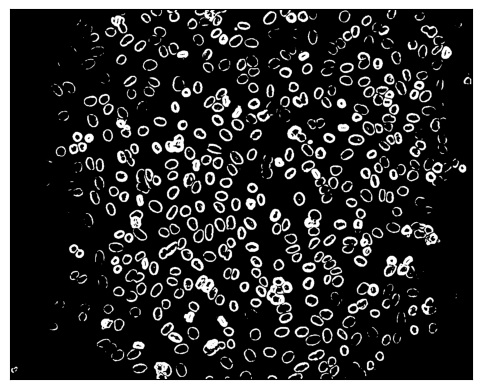

In [19]:
first_order_gaussian_edge_image1 = apply_first_order_gaussian(image1, threshold=2)
first_order_gaussian_edge_image2 = apply_first_order_gaussian(image2, threshold=2)
first_order_gaussian_edge_image3 = apply_first_order_gaussian(image3, threshold=2)

show_binary_image(first_order_gaussian_edge_image1)
show_binary_image(first_order_gaussian_edge_image2)
show_binary_image(first_order_gaussian_edge_image3)

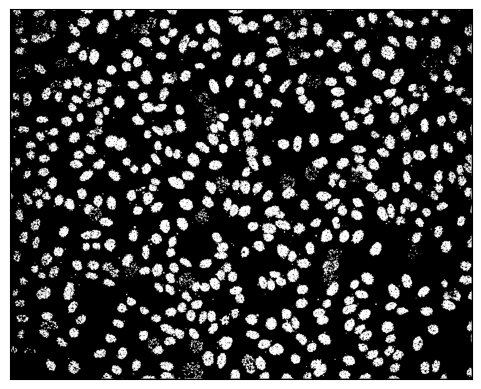

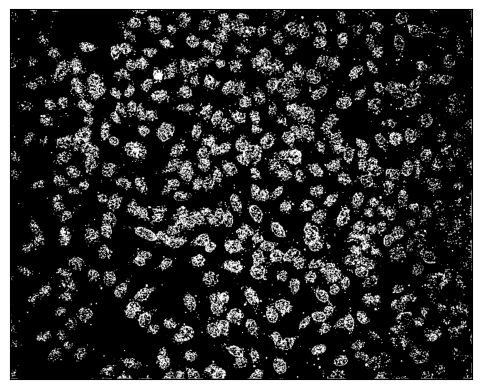

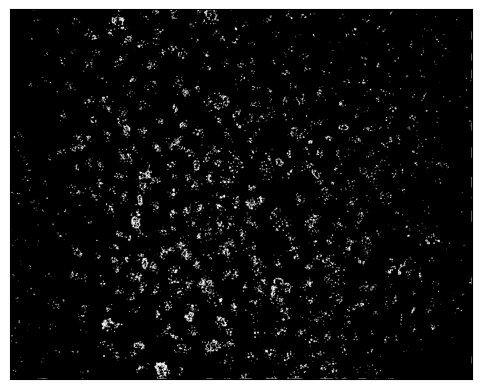

In [52]:
laplacian_edge_image1 = apply_laplacian_filter(image1, threshold=40)
laplacian_edge_image2 = apply_laplacian_filter(image2, threshold=40)
laplacian_edge_image3 = apply_laplacian_filter(image3, threshold=40)

show_binary_image(laplacian_edge_image1)
show_binary_image(laplacian_edge_image2)
show_binary_image(laplacian_edge_image3)

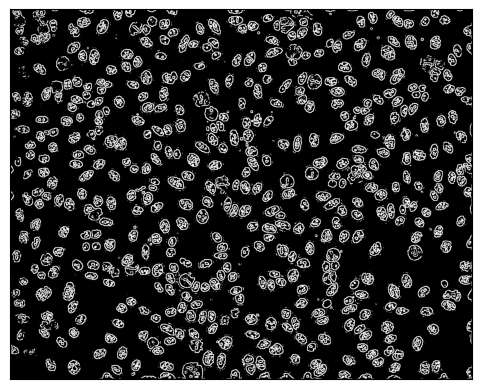

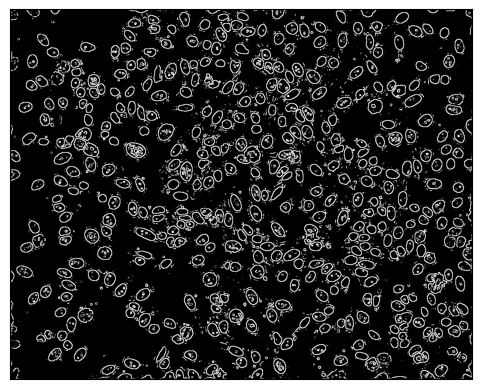

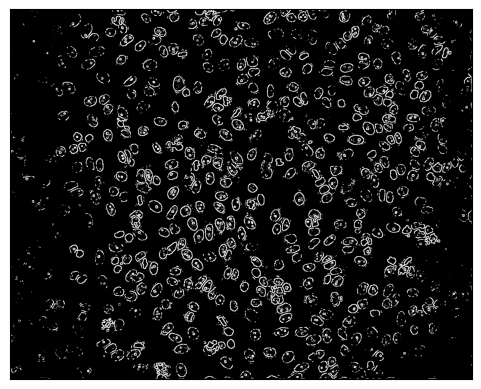

In [28]:
log_edge_image1 = apply_LoG_filter(image1, threshold=2)
log_edge_image2 = apply_LoG_filter(image2, threshold=2)
log_edge_image3 = apply_LoG_filter(image3, threshold=2)

show_binary_image(log_edge_image1)
show_binary_image(log_edge_image2)
show_binary_image(log_edge_image3)

In [40]:
import numpy as np

def compute_metrics(ground_truth, prediction):
    # Ensure the input images are boolean arrays using np.bool_ for correct data type
    ground_truth = ground_truth.astype(np.bool_)
    prediction = prediction.astype(np.bool_)
    
    TP = np.sum((prediction == 1) & (ground_truth == 1))
    TN = np.sum((prediction == 0) & (ground_truth == 0))
    FP = np.sum((prediction == 1) & (ground_truth == 0))
    FN = np.sum((prediction == 0) & (ground_truth == 1))
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    F1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return accuracy, precision, recall, F1


In [45]:
accuracy, precision, recall, F1 = compute_metrics(ground_truth1, sobel_edge_image1)
print(f"SOBEL IMAGE 1: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\n")
accuracy, precision, recall, F1 = compute_metrics(ground_truth2, sobel_edge_image2)
print(f"SOBEL IMAGE 2: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\n")
accuracy, precision, recall, F1 = compute_metrics(ground_truth3, sobel_edge_image3)
print(f"SOBEL IMAGE 3: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\n")

SOBEL IMAGE 1: Accuracy: 0.8546890258789063
Precision: 0.39104311710940376
Recall: 0.7863205267609037
F1 Score: 0.5223283926466532

SOBEL IMAGE 2: Accuracy: 0.8153350830078125
Precision: 0.29141262757017483
Recall: 0.9406945629411309
F1 Score: 0.4449779636687166

SOBEL IMAGE 3: Accuracy: 0.899371337890625
Precision: 0.4730418296006636
Recall: 0.21710654101048085
F1 Score: 0.2976185404507306



In [46]:
accuracy, precision, recall, F1 = compute_metrics(ground_truth1, roberts_edge_image1)
print(f"ROBERTS IMAGE 1: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\n")
accuracy, precision, recall, F1 = compute_metrics(ground_truth2, roberts_edge_image2)
print(f"ROBERTS IMAGE 2: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\n")
accuracy, precision, recall, F1 = compute_metrics(ground_truth3, roberts_edge_image3)
print(f"ROBERTS IMAGE 3: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\n")

ROBERTS IMAGE 1: Accuracy: 0.7924842834472656
Precision: 0.31236336942755655
Recall: 0.87718225202368
F1 Score: 0.46067943743072476

ROBERTS IMAGE 2: Accuracy: 0.7474151611328125
Precision: 0.23386049639891265
Recall: 0.9708756689676569
F1 Score: 0.376928114907744

ROBERTS IMAGE 3: Accuracy: 0.8887550354003906
Precision: 0.45350481265974224
Recall: 0.6479244198242574
F1 Score: 0.5335555548446742



In [47]:
accuracy, precision, recall, F1 = compute_metrics(ground_truth1, first_order_gaussian_edge_image1)
print(f"GAUSSIAN IMAGE 1: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\n")
accuracy, precision, recall, F1 = compute_metrics(ground_truth2, first_order_gaussian_edge_image2)
print(f"GAUSSIAN IMAGE 2: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\n")
accuracy, precision, recall, F1 = compute_metrics(ground_truth3, first_order_gaussian_edge_image3)
print(f"GAUSSIAN IMAGE 3: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\n")

GAUSSIAN IMAGE 1: Accuracy: 0.8063949584960938
Precision: 0.32778443317757805
Recall: 0.8718889694333696
F1 Score: 0.47644905858129044

GAUSSIAN IMAGE 2: Accuracy: 0.7685173034667969
Precision: 0.24943259021627884
Recall: 0.9664061894051036
F1 Score: 0.39652164919336397

GAUSSIAN IMAGE 3: Accuracy: 0.9019599914550781
Precision: 0.500660728580323
Recall: 0.6122631321332287
F1 Score: 0.5508662661256217



In [48]:
accuracy, precision, recall, F1 = compute_metrics(ground_truth1, laplacian_edge_image1)
print(f"LAPLACIAN IMAGE 1: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\n")
accuracy, precision, recall, F1 = compute_metrics(ground_truth2, laplacian_edge_image2)
print(f"LAPLACIAN IMAGE 2: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\n")
accuracy, precision, recall, F1 = compute_metrics(ground_truth3, laplacian_edge_image3)
print(f"LAPLACIAN IMAGE 3: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\n")

LAPLACIAN IMAGE 1: Accuracy: 0.8285491943359375
Precision: 0.26563261823500733
Recall: 0.39493475897064156
F1 Score: 0.31762862556478655

LAPLACIAN IMAGE 2: Accuracy: 0.9003341674804688
Precision: 0.31995493961384297
Recall: 0.23681455053129605
F1 Score: 0.27217721716456994

LAPLACIAN IMAGE 3: Accuracy: 0.8956459045410157
Precision: 0.18959679901508156
Recall: 0.0191436629347919
F1 Score: 0.03477598142646447



In [49]:
accuracy, precision, recall, F1 = compute_metrics(ground_truth1, log_edge_image1)
print(f"LoG IMAGE 1: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\n")
accuracy, precision, recall, F1 = compute_metrics(ground_truth2, log_edge_image2)
print(f"LoG IMAGE 2: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\n")
accuracy, precision, recall, F1 = compute_metrics(ground_truth3, log_edge_image3)
print(f"LoG IMAGE 3: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\n")

LoG IMAGE 1: Accuracy: 0.889923095703125
Precision: 0.46955212220269116
Recall: 0.6898408239700374
F1 Score: 0.5587686624219405

LoG IMAGE 2: Accuracy: 0.9165740966796875
Precision: 0.4796837955018797
Recall: 0.710084929806872
F1 Score: 0.5725755384434976

LoG IMAGE 3: Accuracy: 0.9110748291015625
Precision: 0.5609560394371282
Recall: 0.43453162511362664
F1 Score: 0.489716041923875



In [50]:
log_edge_image1.shape

(1024, 1280)

In [51]:
ground_truth3.shape

(1024, 1280)

# MOVE ON TO TASK 3 AND IMPlEMENT HED

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class HED(nn.Module):
    def __init__(self):
        super(HED, self).__init__()
        # Load the pre-trained VGG16 model and list its features
        # vgg16_features = models.vgg16(pretrained=True).features
        vgg16_features = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features

        
        self.conv1 = nn.Sequential(*vgg16_features[:4])  # First conv block
        self.conv2 = nn.Sequential(*vgg16_features[4:9])  # Second conv block
        self.conv3 = nn.Sequential(*vgg16_features[9:16])  # Third conv block
        self.conv4 = nn.Sequential(*vgg16_features[16:23])  # Fourth conv block
        self.conv5 = nn.Sequential(*vgg16_features[23:30])  # Fifth conv block

        # Side output layers
        self.side_output1 = nn.Conv2d(64, 1, kernel_size=1)
        self.side_output2 = nn.Conv2d(128, 1, kernel_size=1)
        self.side_output3 = nn.Conv2d(256, 1, kernel_size=1)
        self.side_output4 = nn.Conv2d(512, 1, kernel_size=1)
        self.side_output5 = nn.Conv2d(512, 1, kernel_size=1)

        # Fusion layer to combine side outputs
        self.fusion = nn.Conv2d(5, 1, kernel_size=1)

    def forward(self, x):
        # Forward pass through each conv block
        out1 = self.conv1(x)
        out2 = self.conv2(out1)
        out3 = self.conv3(out2)
        out4 = self.conv4(out3)
        out5 = self.conv5(out4)

        # Side outputs
        so1 = self.side_output1(out1)
        so2 = self.side_output2(out2)
        so3 = self.side_output3(out3)
        so4 = self.side_output4(out4)
        so5 = self.side_output5(out5)

        # Resize side outputs to match the input size
        so1 = F.interpolate(so1, size=x.size()[2:], mode='bilinear', align_corners=False)
        so2 = F.interpolate(so2, size=x.size()[2:], mode='bilinear', align_corners=False)
        so3 = F.interpolate(so3, size=x.size()[2:], mode='bilinear', align_corners=False)
        so4 = F.interpolate(so4, size=x.size()[2:], mode='bilinear', align_corners=False)
        so5 = F.interpolate(so5, size=x.size()[2:], mode='bilinear', align_corners=False)

        # Concatenate side outputs and pass through the fusion layer
        fused = self.fusion(torch.cat((so1, so2, so3, so4, so5), dim=1))

        return fused, so1, so2, so3, so4, so5


In [37]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class EdgeDetectionDataset(Dataset):
    def __init__(self, img_dir, gt_dir, transform=None):
        self.img_dir = img_dir
        self.gt_dir = gt_dir
        self.transform = transform
        # List of all files in img_dir; adjust if your data structure is different
        self.images = [img for img in os.listdir(img_dir) if img.endswith('.jpg') or img.endswith('.png')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        gt_path = os.path.join(self.gt_dir, self.images[idx].replace('.jpg', '.png'))

        image = Image.open(img_path).convert('RGB')
        gt = Image.open(gt_path).convert('L')  # Ground truth in grayscale

        if self.transform:
            image = self.transform(image)
            gt = self.transform(gt)

        return image, gt


transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the images and edge maps
    transforms.ToTensor(),  # Convert the images and edge maps to PyTorch tensors
])

# Example paths; adjust as needed based on your dataset structure
img_dir = 'data/BIPED/edges/imgs/train/rgbr/real'
gt_dir = 'data/BIPED/edges/edge_maps/train/rgbr/real'

edge_dataset = EdgeDetectionDataset(img_dir=img_dir, gt_dir=gt_dir, transform=transform)

train_loader = DataLoader(edge_dataset, batch_size=4, shuffle=True)


In [38]:
class HEDLoss(nn.Module):
    def __init__(self):
        super(HEDLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, preds, target):
        fused_output, *side_outputs = preds
        loss = self.bce_loss(fused_output, target)
        for side_output in side_outputs:
            loss += self.bce_loss(side_output, target)
        return loss

def train(model, dataloader, optimizer, loss_fn, epochs, device):
    model.train()
    model.to(device)
    
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            predictions = model(images)
            loss = loss_fn(predictions, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}")

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HED()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = HEDLoss()

# Assuming 'train_loader' is your DataLoader for training data
train(model, train_loader, optimizer, loss_fn, epochs=20, device=device)


/home/ulixe/Neural-Computation/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ulixe/Neural-Computation/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/ulixe/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:20<00:00, 26.9MB/s] 


Epoch 1, Loss: 1.5402045798301698
Epoch 2, Loss: 0.9528669142723083
Epoch 3, Loss: 0.8453404104709625
Epoch 4, Loss: 0.8234673881530762
Epoch 5, Loss: 0.8139094889163971
Epoch 6, Loss: 0.805888786315918
Epoch 7, Loss: 0.7995123398303986
Epoch 8, Loss: 0.7934986722469329
Epoch 9, Loss: 0.7898067474365235
Epoch 10, Loss: 0.7821286594867707
Epoch 11, Loss: 0.778187221288681
Epoch 12, Loss: 0.7762829983234405
Epoch 13, Loss: 0.7719115316867828
Epoch 14, Loss: 0.7671757769584656
Epoch 15, Loss: 0.7637524902820587
Epoch 16, Loss: 0.7620929086208343
Epoch 17, Loss: 0.7598850047588348
Epoch 18, Loss: 0.7569639098644256
Epoch 19, Loss: 0.7555681711435318
Epoch 20, Loss: 0.755917444229126
